In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("whitegrid")

In [3]:
# Load your dataset (change path if needed)
df = pd.read_csv("laptop_prices.csv")

print("Shape:", df.shape)
df.head()

Shape: (1275, 23)


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [4]:
# Clean column names
df.columns = [col.strip() for col in df.columns]

# Convert Yes/No columns to binary
for col in ['Touchscreen', 'IPSpanel', 'RetinaDisplay']:
    df[col] = df[col].astype(str).str.lower().map({'yes': 1, 'no': 0})

# Convert numeric columns
num_cols = ['Inches', 'Ram', 'Weight', 'Price_euros', 'ScreenW', 'ScreenH', 
            'CPU_freq', 'PrimaryStorage', 'SecondaryStorage']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing Price
df = df.dropna(subset=['Price_euros'])
df.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,1,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,0,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,0,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,1,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,1,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [5]:
# Create Pixels Per Inch (PPI)
df['Screen_pixels'] = np.sqrt(df['ScreenW']**2 + df['ScreenH']**2)
df['PPI'] = df['Screen_pixels'] / df['Inches']

# Combine storage
df['TotalStorageGB'] = df['PrimaryStorage'].fillna(0) + df['SecondaryStorage'].fillna(0)

# Create simplified CPU feature
df['CPU_series'] = df['CPU_model'].str.extract(r'([A-Za-z]+\s*i?\d+)', expand=False).fillna(df['CPU_model'])

df.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,Screen_pixels,PPI,TotalStorageGB,CPU_series
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,128,0,SSD,No,Intel,Iris Plus Graphics 640,3018.873962,226.983005,128,Core i5
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,128,0,Flash Storage,No,Intel,HD Graphics 6000,1698.116604,127.677940,128,Core i5
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,256,0,SSD,No,Intel,HD Graphics 620,2202.907170,141.211998,256,Core i5
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,512,0,SSD,No,AMD,Radeon Pro 455,3396.233208,220.534624,512,Core i7
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,256,0,SSD,No,Intel,Iris Plus Graphics 650,3018.873962,226.983005,256,Core i5


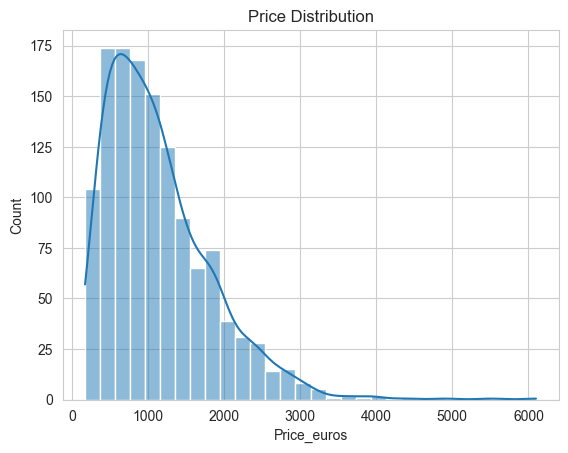

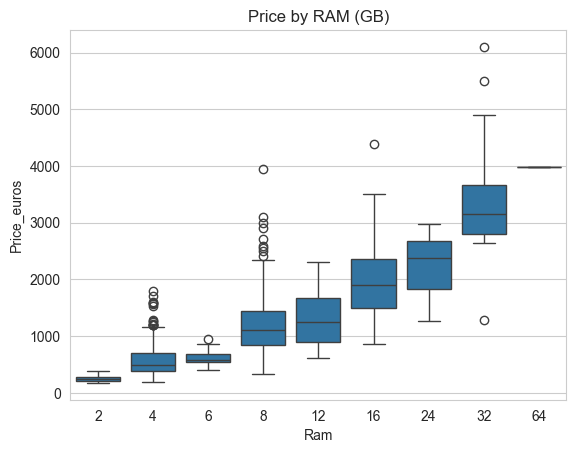

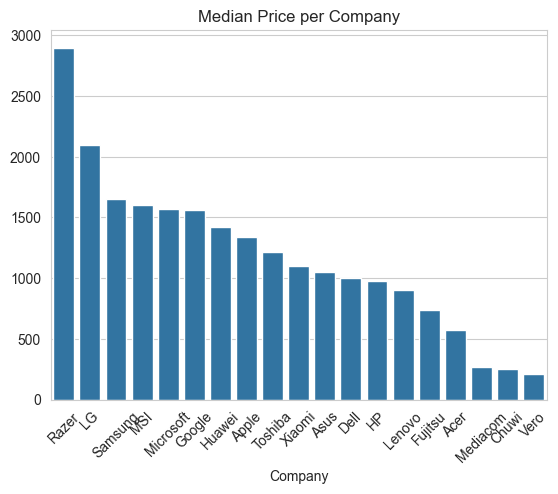

In [6]:
# Price distribution
sns.histplot(df['Price_euros'], bins=30, kde=True)
plt.title("Price Distribution")
plt.show()

# Price vs RAM
sns.boxplot(x='Ram', y='Price_euros', data=df)
plt.title("Price by RAM (GB)")
plt.show()

# Median price by company
company_price = df.groupby('Company')['Price_euros'].median().sort_values(ascending=False)
sns.barplot(x=company_price.index, y=company_price.values)
plt.xticks(rotation=45)
plt.title("Median Price per Company")
plt.show()


In [7]:
features_num = ['Inches', 'Ram', 'Weight', 'CPU_freq', 'PPI', 'TotalStorageGB']
features_cat = ['Company', 'TypeName', 'OS', 'PrimaryStorageType', 
                'SecondaryStorageType', 'GPU_company']

df_model = df[features_num + features_cat + ['Price_euros']].dropna()

X = df_model[features_num + features_cat]
y = df_model['Price_euros']

# Log-transform target for better stability
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [9]:
# Preprocessing
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, features_num),
        ('cat', cat_transformer, features_cat)
    ])

# Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Inches', 'Ram', 'Weight',
                                                   'CPU_freq', 'PPI',
                                                   'TotalStorageGB']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Company', 'TypeName', 'OS',
                                                   'PrimaryStorageType',
                                                   'SecondaryStorageType',
                                                   'GPU_company'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Mean Squared Error: 85182.83
R² Score: 0.83


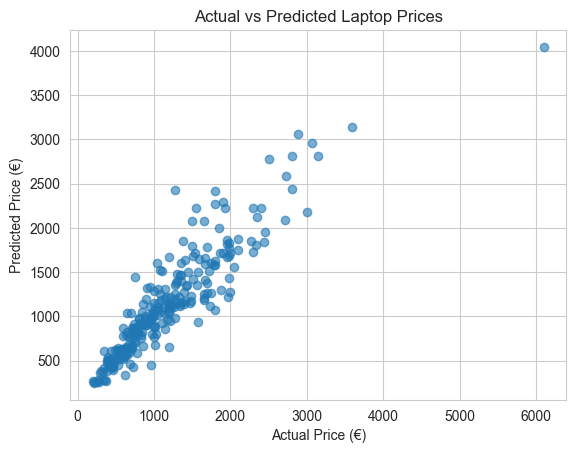

In [10]:
# Predict and evaluate
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()


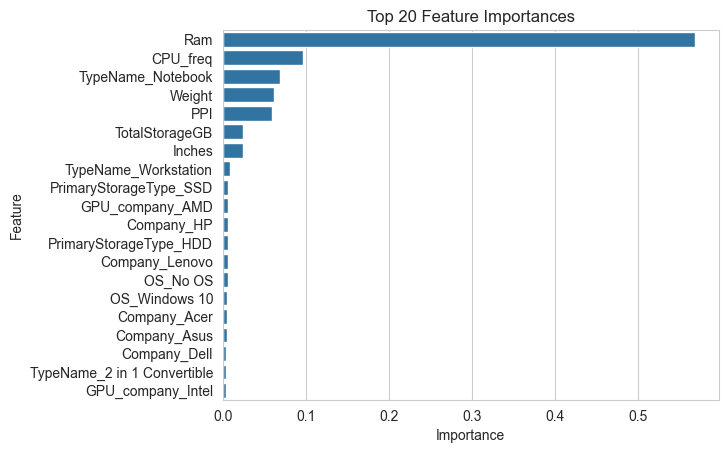

In [11]:
rf = model.named_steps['regressor']
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

cat_names = ohe.get_feature_names_out(features_cat)
feature_names = np.concatenate([features_num, cat_names])

importance = rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Top 20 Feature Importances")
plt.show()


In [12]:
df.to_csv("laptops_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as laptops_cleaned.csv")

✅ Cleaned dataset saved as laptops_cleaned.csv
